# Sistema de Recomendación de Licitaciones (Modelado) 📄✨

<br>

<div class="alert alert-block alert-warning">
<b> Integrantes:</b> &nbsp; Daniel Andrade, Gabriel Cubides, Dewith Miramón & Santiago Prado<br>
</div>

<br>

Para el proyecto final decidimos crear un sistema de recomendación de licitaciones, esto con el fin de que  empresas tengan mayores posibilidades de encontrar oportunidades de negocio relevantes.

Para ello construimos un sistema de recomendación híbrido, es decir, una combinación de filtro colaborativo y filtro basado en contenido. Para el contenido usaremos varios atributos de las licitaciones como la cuantía, la entidad, el bien/servicio solicitado, entre otros.

Los datasets se obtuvieron de Datos Abiertos:
[SECOP II - Procesos de Contratación](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Procesos-de-Contrataci-n/p6dx-8zbt) y
[SECOP II - Proponentes por Proceso](https://www.datos.gov.co/Gastos-Gubernamentales/Proponentes-por-Proceso-SECOP-II/hgi6-6wh3).


<div style="text-align:center">
<img src="https://images.pexels.com/photos/8278870/pexels-photo-8278870.jpeg?cs=srgb&dl=pexels-antoni-shkraba-production-8278870.jpg&fm=jpg" alt="A Man in Black Suit Holding Paper Documents" width="700"/>
</div>
<sup>
Photo by ANTONI SHKRABA production from <a href="https://www.pexels.com/photo/a-man-in-black-suit-holding-paper-documents-8278870/">Pexels</a>
</sup>


<!---
![imagen.png](https://images.pexels.com/photos/8278870/pexels-photo-8278870.jpeg?cs=srgb&dl=pexels-antoni-shkraba-production-8278870.jpg&fm=jpg)
-->



#### Cargue de  librerías

In [ ]:
# Misc
import gc
import re
import textwrap
import pickle
from tqdm import tqdm 

# Data
import scipy 
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
pd.set_option('display.max_columns', 100)

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotx
plt.style.use(matplotx.styles.dracula)
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Machine Learning
from lightfm import LightFM
from lightfm.evaluation import (
    precision_at_k,
    recall_at_k,
    auc_score
)
from category_encoders.binary import BinaryEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import (
    preprocessing, 
    model_selection,
    impute,
    compose, 
    pipeline, 
    metrics,
    decomposition
)

#### Lectura de datos

In [ ]:
bidders = pd.read_csv('/work/data/02_intermediate/bidders.csv')
contracts = pd.read_csv('/work/data/02_intermediate/contracts.csv')

In [ ]:
ratings_matrix = pd.read_csv('/work/data/03_processed/ratings_all.csv', index_col=0)
probas_matrix = pd.read_csv('/work/data/03_processed/probas_all.csv', index_col=0)

In [ ]:
with open('/work/data/03_processed/train_indexs_list.pickle', 'rb') as f:
    train_indexs_list = pickle.load(f)
with open('/work/data/03_processed/test_indexs_list.pickle', 'rb') as f:
    test_indexs_list = pickle.load(f)

In [ ]:
with open('/work/data/03_processed/train_ratings_list.pickle', 'rb') as f:
    train_ratings_list = pickle.load(f)
with open('/work/data/03_processed/train_probas_list.pickle', 'rb') as f:
    train_probas_list = pickle.load(f)

In [ ]:
with open('/work/data/03_processed/test_ratings_list.pickle', 'rb') as f:
    test_ratings_list = pickle.load(f)
with open('/work/data/03_processed/test_list.pickle', 'rb') as f:
    test_list = pickle.load(f)

<br>
<br>
<br>

## Modelado 🤖
---

Cambiamos los IDs de los contratos a solo números por compatibilidad con librerías y rapidez.

In [ ]:
bidder_ids = list(ratings_matrix.index)
bid_ids = list(ratings_matrix.columns)
bid_ids = [int(id.replace('CO1.REQ.', '')) for id in bid_ids]

In [ ]:
ratings_matrix.columns = bid_ids
probas_matrix.columns = bid_ids

for df_list in [train_ratings_list, train_probas_list, test_ratings_list]:
    for df in df_list:
        df.columns = bid_ids

for df in [bidders, contracts] + test_list:
    df.bid_id = df.bid_id.str.replace('CO1.REQ.', '', regex=False).astype(np.int64)

In [ ]:
bidders = bidders[['contractor_id', 'bid_id', 'rating']]

### Filtro colaborativo de usuarios

#### Métricas de evaluación

> **Precision at k** es la proporción de elementos recomendados en el conjunto top-k que son relevantes (o verdaderos positivos). Su interpretación es la siguiente: supongamos que mi precisión en un problema de recomendación top-10 es del 80%. Esto significa que el 80% de las recomendaciones que hago son relevantes para el usuario.

Matemáticamente, la precision@k se define así:

```
Precision@k = (nº de elementos en k recomendaciones que son relevantes) / (nº de k recomendaciones)
```

<br>


> **Recall at k** es la proporción de elementos relevantes (verdaderos positivos) encontrados en las recomendaciones top-k. Supongamos que calculamos el recall de 10 elementos y descubrimos que el 40% está en nuestro sistema de recomendación top-10. Esto significa que el 40% del número total de elementos relevantes aparece en los resultados del top-k.

Matemáticamente, el recall@k se se define así:

```
Recall@k = (nº de elementos en k recomendaciones que son relevantes) / (nº total de elementos relevantes)
```

In [ ]:
%%time
precision_test_means = []
recall_test_means = []
auc_test_means = []

factors = [4, 8, 16, 32, 64, 128, 256, 512]
for factor in factors:
    print(f'Número de Factores: {factor}')
    model = LightFM(loss='warp',
                   random_state=42,
                   no_components=factor,
                   learning_rate=0.05,
                   user_alpha=0.003,
                   item_alpha=0.003)
    cv_metrics = {
        'precision': [],
        'recall': [],
        'auc': []
    }
    for fold in tqdm(range(len(train_ratings_list))):
        train = csr_matrix(train_ratings_list[fold].values)
        test = csr_matrix(test_ratings_list[fold].values)
        model.fit(train, epochs=50, verbose=False)
        cv_metrics['precision'] = precision_at_k(model, test, train, k=10, check_intersections=False).mean()
        cv_metrics['recall'] = recall_at_k(model, test, train, k=10, check_intersections=False).mean()
        cv_metrics['auc'] = auc_score(model, test, train, check_intersections=False).mean()

    print('  Recall: {:.3f}'.format(np.mean(cv_metrics['recall'])))
    print('  Precision: {:.3f}'.format(np.mean(cv_metrics['precision'])))
    print('  AUC: {:.3f}'.format(np.mean(cv_metrics['auc'])))

    precision_test_means.append(np.mean(cv_metrics['precision']))
    recall_test_means.append(np.mean(cv_metrics['recall']))
    auc_test_means.append(np.mean(cv_metrics['auc']))

Número de Factores: 4
100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
  Recall: 0.041
  Precision: 0.011
  AUC: 0.705
Número de Factores: 8
100%|██████████| 5/5 [00:02<00:00,  1.72it/s]
  Recall: 0.109
  Precision: 0.026
  AUC: 0.793
Número de Factores: 16
100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
  Recall: 0.160
  Precision: 0.040
  AUC: 0.828
Número de Factores: 32
100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
  Recall: 0.196
  Precision: 0.049
  AUC: 0.852
Número de Factores: 64
100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
  Recall: 0.239
  Precision: 0.060
  AUC: 0.867
Número de Factores: 128
100%|██████████| 5/5 [00:12<00:00,  2.48s/it]
  Recall: 0.286
  Precision: 0.070
  AUC: 0.852
Número de Factores: 256
100%|██████████| 5/5 [00:21<00:00,  4.36s/it]
  Recall: 0.300
  Precision: 0.074
  AUC: 0.847
Número de Factores: 512
100%|██████████| 5/5 [00:38<00:00,  7.63s/it]  Recall: 0.311
  Precision: 0.076
  AUC: 0.832
CPU times: user 1min 33s, sys: 74.2 ms, total: 1min 33s
Wall tim

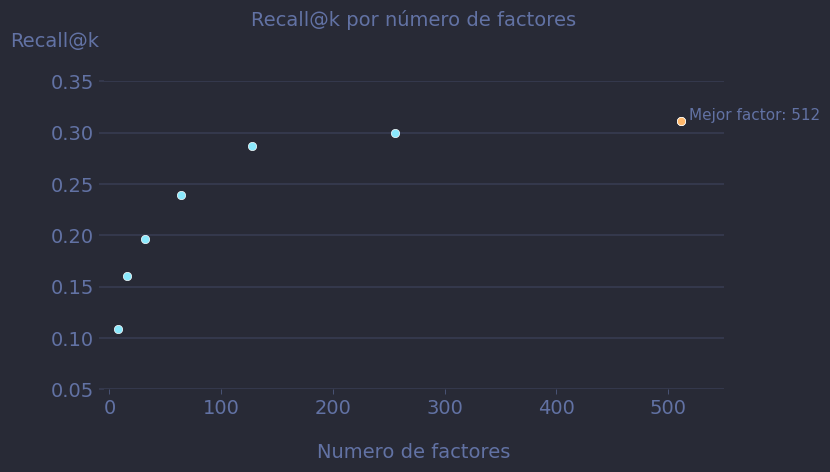

In [ ]:
with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)):
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=factors, y=recall_test_means)
    sns.scatterplot(x=[factors[np.argmax(recall_test_means)]], 
                    y=[np.max(recall_test_means)], label='Best one')
    plt.text(factors[np.argmax(recall_test_means)] + 7, 
             np.max(recall_test_means) + 0.002, 
             f'Mejor factor: {factors[np.argmax(recall_test_means)]}', 
             fontsize=11)
    plt.xlabel('Numero de factores')
    plt.title('Recall@k por número de factores')
    plt.xlim(-5, 550)
    plt.ylim(0.05, 0.35)
    matplotx.ylabel_top("Recall@k")
    matplotx.line_labels()
    sns.despine(bottom=True, left=True)
    plt.grid(True, axis='y')
    plt.legend([])
    plt.show()

In [ ]:
lightfm_models = []
for fold_ratings in train_ratings_list:
    model = LightFM(loss='warp',
                    random_state=42,
                    no_components=factors[np.argmax(recall_test_means)],
                    learning_rate=0.05,
                    user_alpha=0.003,
                    item_alpha=0.003)
    fold_train = csr_matrix(fold_ratings.values)
    model.fit(fold_train, epochs=50, verbose=False)
    lightfm_models.append(model)

### Filtro colaborativo de items

In [ ]:
contracts_collab_sim_list = []
for fold_probas in train_probas_list:
    contracts_collab_sim = metrics.pairwise.cosine_similarity(
        X=csr_matrix(fold_probas.transpose()), 
        dense_output=False
    )
    contracts_collab_sim_df = pd.DataFrame.sparse.from_spmatrix(
        contracts_collab_sim,
        index=fold_probas.columns,
        columns=fold_probas.columns
    )
    contracts_collab_sim_list.append(contracts_collab_sim_df)

In [ ]:
contracts_collab_sim

<3564x3564 sparse matrix of type '<class 'numpy.float64'>'
	with 69504 stored elements in Compressed Sparse Row format>

Probamos la similitud coseno con un contrato y obtenemos los 3 más similares.

In [ ]:
def print_contract(bid_id, sim=1.0):
    bid_info = contracts.loc[contracts['bid_id'] == bid_id].iloc[0]
    print('—' * 80)
    print('{:^80}'.format(str(bid_info['bid_id']) + f" (Similitud {sim:.2f})"))
    description = ' ' + bid_info['bid_title'].strip().capitalize()
    print('\n '.join(textwrap.wrap(description, 70, break_long_words=False)))
    print('-' * 80)
    print('{:<16} {:<30}'.format(' Entidad:', bid_info['entity']))
    print('{:<16} {:<30}'.format(' Departamento:', bid_info['entity_department']))
    print('{:<16} ${:<30,.0f}'.format(' Cuantía:', bid_info['value']))
    print('{:<16} {:<30}'.format(' Tipo contrato:', bid_info['bid_type']))
    print('{:<16} {:<30}'.format(' Segmento:', bid_info['unspsc_segment']))
    print('—' * 80)
    print()

In [ ]:
bid_id_example = contracts.iloc[11]['bid_id']
most_similar_bids = (
    contracts_collab_sim_list[0].loc[bid_id_example].sort_values(ascending=False)[0:5]
)

print_contract(bid_id_example, sim=1.0)
print('#' * 80, end='\n\n')
count = 0
for bid_id, sim in most_similar_bids.iteritems():
    if bid_id != bid_id_example:
        try:
            print_contract(bid_id, sim=sim)
        except:
            continue
        count += 1
        if count == 3:
            break

————————————————————————————————————————————————————————————————————————————————
                            1338116 (Similitud 1.00)                            
 Adecuación centro de acopio
--------------------------------------------------------------------------------
 Entidad:        SENA REGIONAL CUNDINAMARCA Grupo Administrativo CBA
 Departamento:   Cundinamarca                  
 Cuantía:        $39,634,156                    
 Tipo contrato:  Servicios de aprovisionamiento
 Segmento:       Servicios de Edificación, Construcción de Instalaciones y Mantenimiento
————————————————————————————————————————————————————————————————————————————————

################################################################################

————————————————————————————————————————————————————————————————————————————————
                            707068 (Similitud 0.50)                             
 Interventoria obras de emergencias colegios distritales (presentación
 de oferta)
----------------

### Filtro basado en contenido de items
Revisamos cuantos valores únicos tiene cada columna categoricas

In [ ]:
contracts_backup = contracts.copy()
contracts = contracts_backup.drop_duplicates(subset='bid_id')

In [ ]:
contracts.select_dtypes(include=[object, 'category']).nunique()

entity                579
entity_department      30
bid_title            2795
published_at         1011
bid_modality           11
is_awarded              1
contractor           1752
bid_type               10
unspsc_segment         52
dtype: int64

Preprocesamos las columnas de las licitaciones

In [ ]:
numerical_cols = ['value']
categorical_cols = ['bid_modality', 'bid_type', 'unspsc_segment', 'entity_department']
high_categorical_cols = ['entity']

preprocessor = compose.make_column_transformer(
    (preprocessing.RobustScaler(), numerical_cols),
    (preprocessing.OneHotEncoder(handle_unknown='infrequent_if_exist', 
                                 min_frequency=0.01, sparse=True), 
        categorical_cols),
    (BinaryEncoder(handle_unknown='value', handle_missing='value'), 
        high_categorical_cols),
     remainder='drop',
     sparse_threshold=1.0,
     n_jobs=-1,
)

In [ ]:
contracts_cbf = preprocessor.fit_transform(contracts)
contracts_cbf

<2917x62 sparse matrix of type '<class 'numpy.float64'>'
	with 25988 stored elements in Compressed Sparse Row format>

Ahora calculamos la similitud usando la distancia euclideana

In [ ]:
contracts_content_sim = metrics.pairwise_distances(X=contracts_cbf,
                                                   metric='euclidean',
                                                   n_jobs=-1)

In [ ]:
contracts_content_sim[:7, :7].round(2)

array([[ 0.  ,  2.84,  2.66, 10.98, 58.86,  3.56,  3.16],
       [ 2.84,  0.  ,  3.04, 10.82, 58.6 ,  3.43,  2.83],
       [ 2.66,  3.04,  0.  , 11.18, 59.09,  3.57,  3.02],
       [10.98, 10.82, 11.18,  0.  , 48.22,  8.97, 10.97],
       [58.86, 58.6 , 59.09, 48.22,  0.  , 56.93, 58.73],
       [ 3.56,  3.43,  3.57,  8.97, 56.93,  0.  ,  3.51],
       [ 3.16,  2.83,  3.02, 10.97, 58.73,  3.51,  0.  ]])

In [ ]:
contracts_content_sim_df = pd.DataFrame(
    contracts_content_sim,
    index=contracts['bid_id'].values,
    columns=contracts['bid_id'].values
)

Probamos la similitud coseno con el primer contrato y obtenemos los 3 más similares.

In [ ]:
bid_id_example = contracts.iloc[12]['bid_id']
most_similar_bids = contracts_content_sim_df.loc[bid_id_example].sort_values(ascending=True)[1:4]

print_contract(bid_id_example, sim=0)
print('#' * 80, end='\n\n')
for bid_id, sim in most_similar_bids.iteritems():
    print_contract(bid_id, sim=sim)

————————————————————————————————————————————————————————————————————————————————
                            1422805 (Similitud 0.00)                            
 Interventoria a la ejecución a precios unitarios y a monto agotable
 de las obras de conservación de espacio publico y red de ciclorutas en
 bogotá d.c.  grupo i y grupo j (presentación de oferta)
--------------------------------------------------------------------------------
 Entidad:        INSTITUTO DE DESARROLLO URBANO
 Departamento:   Distrito Capital de Bogotá    
 Cuantía:        $2,120,039,600                 
 Tipo contrato:  Interventoría                 
 Segmento:       Servicios Basados en Ingeniería, Investigación y Tecnología
————————————————————————————————————————————————————————————————————————————————

################################################################################

————————————————————————————————————————————————————————————————————————————————
                            1533722 (Simili

<br>
<br>
<br>

## Evaluación 🎖️
---

### Recomendaciones basadas en contratos

In [ ]:
def recommend_contract_based(train_probas, contracts_most_similars, n=10, 
                             reverse=True):
    print('Creating recommendations...')
    contracts_recommended = {}
    for bidder_id in tqdm(train_probas.index):
        bidder_probas = train_probas.loc[bidder_id]
        bids_participated = list(bidder_probas.loc[bidder_probas == 1].index)
        bidder_recommendations = []
        if bids_participated:
            for bid_id in bids_participated:
                try:
                    bidder_recommendations.extend(contracts_most_similars[bid_id]) 
                except KeyError:
                    continue
            bidder_recommendations = sorted(bidder_recommendations, 
                                            key=lambda x: x[1], reverse=reverse)
            bidder_recommendations = [bid_id for bid_id, sim in bidder_recommendations]
            contracts_recommended[bidder_id] = [bid_id for bid_id in bidder_recommendations 
                                                if bid_id not in bids_participated][:n]
        else:
            contracts_recommended[bidder_id] = []
    return contracts_recommended

In [ ]:
%%time
contract_content_recommendations = []

print('Building similars mapping...')
n = 10
contracts_most_similars = {}
for bid_id in tqdm(contracts_content_sim_df.index):
    contracts_most_similars[bid_id] = list(
        contracts_content_sim_df[bid_id].sort_values(ascending=True).head(n+1).items()
    )

for fold, fold_train_probas in enumerate(train_probas_list):
    print(f'Fold {fold + 1}')
    fold_recommendations = recommend_contract_based(
        train_probas=fold_train_probas,
        contracts_most_similars=contracts_most_similars, 
        n=n,
        reverse=False
    )
    contract_content_recommendations.append(fold_recommendations)

Building similars mapping...
100%|██████████| 2917/2917 [00:01<00:00, 2152.33it/s]
Fold 1
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2246.53it/s]
Fold 2
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2251.03it/s]
Fold 3
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2225.83it/s]
Fold 4
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2269.50it/s]
Fold 5
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2365.72it/s]CPU times: user 3.45 s, sys: 16.1 ms, total: 3.47 s
Wall time: 3.45 s



In [ ]:
%%time
contract_collab_recommendations = []

for fold, fold_train_probas in enumerate(train_probas_list):
    print(f'Fold {fold + 1}')
    print('Building similars mapping...')
    contracts_most_similars = {}
    for bid_id in tqdm(contracts_collab_sim_list[fold].index):
        contracts_most_similars[bid_id] = list(
            contracts_collab_sim_list[fold][bid_id].sort_values(ascending=False).head(n+1).items()
        )
    fold_recommendations = recommend_contract_based(
        train_probas=fold_train_probas,
        contracts_most_similars=contracts_most_similars, 
        n=n,
        reverse=True
    )
    contract_collab_recommendations.append(fold_recommendations)

Fold 1
Building similars mapping...
100%|██████████| 3564/3564 [00:03<00:00, 1155.05it/s]
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2160.37it/s]
Fold 2
Building similars mapping...
100%|██████████| 3564/3564 [00:03<00:00, 1158.50it/s]
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2135.93it/s]
Fold 3
Building similars mapping...
100%|██████████| 3564/3564 [00:03<00:00, 1150.68it/s]
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2134.20it/s]
Fold 4
Building similars mapping...
100%|██████████| 3564/3564 [00:03<00:00, 1126.43it/s]
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2082.68it/s]
Fold 5
Building similars mapping...
100%|██████████| 3564/3564 [00:03<00:00, 1117.80it/s]
Creating recommendations...
100%|██████████| 938/938 [00:00<00:00, 2146.88it/s]CPU times: user 17.9 s, sys: 70.8 ms, total: 17.9 s
Wall time: 17.9 s



### Recomendaciones basadas en oferentes

In [ ]:
bidder_ids_mapping = {k: v for k, v in zip(bidder_ids, range(len(bidder_ids)))}
bid_ids_mapping = {k: v for k, v in zip(bid_ids, range(len(bid_ids)))}

all_interactions = [(bidder_ids_mapping[bidder_id], bid_ids_mapping[bid_id]) 
                    for bidder_id in bidder_ids for bid_id in bid_ids]

bidders_iids = np.array([interaction[0] for interaction in all_interactions])
bid_iids = np.array([interaction[1] for interaction in all_interactions])

In [ ]:
%%time
lightfm_preds_list = []
for fold in range(len(train_indexs_list)):
    print(f'Fold {fold + 1}')
    print('  Creating dataset...')
    bidders_all_fold = pd.DataFrame(
        [(bidder_id, bid_id, 0) for bidder_id in bidder_ids for bid_id in bid_ids],
        columns=['contractor_id', 'bid_id', 'rating']
    )
    print('  Predicting...')
    rating_preds = lightfm_models[fold].predict(user_ids=bidders_iids, 
                                                item_ids=bid_iids, num_threads=4)
    bidders_all_fold['rating'] = rating_preds
    lightfm_preds_list.append(bidders_all_fold)

Fold 1
  Creating dataset...
  Predicting...
Fold 2
  Creating dataset...
  Predicting...
Fold 3
  Creating dataset...
  Predicting...
Fold 4
  Creating dataset...
  Predicting...
Fold 5
  Creating dataset...
  Predicting...
CPU times: user 13.6 s, sys: 786 ms, total: 14.4 s
Wall time: 13.2 s


In [ ]:
%%time
svd_preds_matrix_list = []
for preds in lightfm_preds_list:
    rating_pred_matrix = pd.pivot_table(
        preds, values='rating', index=['contractor_id'],
        columns=['bid_id'], aggfunc=np.mean, fill_value=0)
    svd_preds_matrix_list.append(rating_pred_matrix)

CPU times: user 11 s, sys: 1.19 s, total: 12.2 s
Wall time: 12.2 s


In [ ]:
def recommend_bidder_based(ratings, ratings_pred, n=10):
    print('Creating recommendations...')
    contracts_recommended = {}
    for bidder_id in tqdm(ratings_pred.index):
        bidder_ratings = ratings.loc[bidder_id]
        bids_participated = list(bidder_ratings.loc[bidder_ratings >= 1].index)
        bidder_recommendations = list(
            ratings_pred.loc[bidder_id].sort_values(ascending=False).head(n+n).items()
        )
        bidder_recommendations = sorted(bidder_recommendations, 
                                        key=lambda x: x[1], reverse=True)
        bidder_recommendations = [bid_id for bid_id, sim in bidder_recommendations]
        contracts_recommended[bidder_id] = [bid_id for bid_id in bidder_recommendations 
                                            if bid_id not in bids_participated][:n]
    return contracts_recommended

In [ ]:
sorted([('a', 3), ('b', 5)], key=lambda x: x[1], reverse=True)

[('b', 5), ('a', 3)]

In [ ]:
%%time
bidder_collab_recommendations = []
svd_folds = zip(train_ratings_list, svd_preds_matrix_list)
for fold, (fold_ratings, fold_ratings_pred) in enumerate(svd_folds):
    print(f'Fold {fold + 1}')
    fold_recommendations = recommend_bidder_based(
        ratings=fold_ratings,
        ratings_pred=fold_ratings_pred, 
        n=10
    )
    bidder_collab_recommendations.append(fold_recommendations)

Fold 1
Creating recommendations...
100%|██████████| 938/938 [00:02<00:00, 336.87it/s]
Fold 2
Creating recommendations...
100%|██████████| 938/938 [00:02<00:00, 328.91it/s]
Fold 3
Creating recommendations...
100%|██████████| 938/938 [00:02<00:00, 327.53it/s]
Fold 4
Creating recommendations...
100%|██████████| 938/938 [00:02<00:00, 326.81it/s]
Fold 5
Creating recommendations...
100%|██████████| 938/938 [00:02<00:00, 336.04it/s]CPU times: user 14.2 s, sys: 66.6 ms, total: 14.2 s
Wall time: 14.2 s



### Cálculo de recall

In [ ]:
def precisionk(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recallk(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [ ]:
bidder_collab_recommendations[0][901282641] 

[1972611,
 1562218,
 2916431,
 838906,
 1851634,
 2242785,
 2972411,
 851152,
 2998143,
 2701811]

In [ ]:
participated_maks = test_list[0].contractor_id == 901282641
actual = list(
    test_list[0].loc[participated_maks]
    .sort_values('rating', ascending=False)['bid_id'].values
)
actual

[1448520, 1874049, 1549622, 2987569]

In [ ]:
test_list[0]

,contractor_id,bid_id,rating
89,6460048,2548743,1
497,804005718,1521009,1
797,900369368,1637315,1
849,805026666,1318302,1
1214,830081925,1265212,1
...,...,...,...
1183850,901563205,2947111,1
1184870,92153531,2211448,1
1185654,92153531,843742,1
1188310,830089097,860203,1


In [ ]:
%%time
k = 10
fold_recall = []
fold_precision = []
fold_no_recommendations = []
for fold in range(len(train_ratings_list)):
    print(f'Fold {fold + 1}')
    bidders_recall = []
    bidders_precision = []
    bidders_no_recomms = []
    for bidder_id in tqdm(test_list[fold].contractor_id.unique(), leave=False):
        k = 10
        participated_maks = test_list[fold].contractor_id == bidder_id
        actual = list(
            test_list[fold].loc[participated_maks]
            .sort_values('rating', ascending=False)['bid_id'].values
        )
        predicted = (
            #bidder_collab_recommendations[fold][bidder_id]
            #+ contract_collab_recommendations[fold][bidder_id]
            contract_content_recommendations[fold][bidder_id]
        )
        bidders_recall.append(recallk(actual, predicted, k))
        bidders_precision.append(precisionk(actual, predicted, k))
        bidders_no_recomms.append(len(predicted))

    fold_recall.append(np.mean(bidders_recall))
    fold_precision.append(np.mean(bidders_precision))
    fold_no_recommendations.append(np.mean(bidders_no_recomms))
    print(f'  Mean recall fold: {round(np.mean(bidders_recall), 3)}')
    print(f'  Mean precision fold: {round(np.mean(bidder_precision), 3)}')
    print(f'  Mean recommendations fold: {round(np.mean(bidder_no_recomms), 2)}')

print('_' * 50)
print(f'Mean recall all folds: {round(np.mean(fold_recall), 3)}')
print(f'Mean precision all folds: {round(np.mean(fold_precision), 3)}')
print(f'Mean recommendations all folds: {round(np.mean(fold_no_recommendations), 2)}')

Fold 1
  Mean recall fold: 0.005
  Mean precision fold: 0.0
  Mean recommendations fold: 19.41
Fold 2
  Mean recall fold: 0.003
  Mean precision fold: 0.0
  Mean recommendations fold: 19.41
Fold 3
  Mean recall fold: 0.001
  Mean precision fold: 0.0
  Mean recommendations fold: 19.41
Fold 4
  Mean recall fold: 0.007
  Mean precision fold: 0.0
  Mean recommendations fold: 19.41
Fold 5
                                                     Mean recall fold: 0.002
  Mean precision fold: 0.0
  Mean recommendations fold: 19.41
__________________________________________________
Mean recall all folds: 0.004
Mean precision all folds: 0.001
Mean recommendations all folds: 10.0
CPU times: user 2.97 s, sys: 161 ms, total: 3.13 s
Wall time: 2.93 s


<br>
<br>
<br>

## Siguientes pasos ⏭️
---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=788609fb-0659-4783-a04c-b2e97d409606' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>